In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, "../")

# Import the laser_input module to define our initial laser object
from fourier_prop.laser_input import (
    advanced_parameters,
    input_laser_field, 
    laser_parameters, 
    propagation_parameters,
    constants,
    utils
)

# Import the propagator module to propagate our input laser field to the defined position from the focus
from fourier_prop.propagator import propagator

# Import the read_laser module to interpolate the laser field values to a PIC simulation grid
from fourier_prop.read_laser import (
    read_laser,
    sim_grid_parameters
)

# Import the laser_visualization module so we can quickly plot the laser field
from fourier_prop.laser_visualization import laser_visualization

## Stage 0: Initial Parameters

We first begin by setting all of our initial parameters for our laser. To start, we define the propagation parameters. Then we define the laser parameters and finally the advanced parameters.

The **propagation parameters** are relevant to the propagation of the laser beam from the focusing optic to the desired position away from the focus. This will include parameters such as input/output plane resolutions and propagation type (rayleigh-sommerfeld or fresnel).

The **laser parameters** are relevant for the characteristics of the laser beam. This includes parameters such as polarization type, temporal full-width-at-half-max (FWHM), and distance from the focus. 

The **advanced parameters** only contains one parameter for now, but was made separate as more parameters will fall under category in the future. The parameter is `center_peak_E_at_0` which, if set to `True`, will roll the output laser field so that the peak E field value will be position at `time = 0`. Otherwise the peak E field may be slightly before or after `time = 0`, since the default propagation has `time = 0` corresponding to `distance_from_focusing_optic_to_propagation_position / c`.  

In [2]:
# Propagation Parameters

SPATIAL_DIMENSIONS = 2
PROPAGATION_TYPE = constants.RAYLEIGH_SOMMERFELD
MONOCHROMATIC_ASSUMPTION = False

# INPUT PLANE
Y_INPUT_RANGE = 10 * 7.5e4
Z_INPUT_RANGE = Y_INPUT_RANGE
N_Y_INPUT = (2 ** 9)
N_Z_INPUT = (2 ** 9)
Y_VALS_INPUT = np.linspace(-Y_INPUT_RANGE, Y_INPUT_RANGE, N_Y_INPUT)
Z_VALS_INPUT = np.linspace(-Z_INPUT_RANGE, Z_INPUT_RANGE, N_Z_INPUT)

# OUTPUT PLANE
Y_OUTPUT_RANGE = 30
Z_OUTPUT_RANGE = Y_OUTPUT_RANGE
N_Y_OUTPUT = (2 ** 8) + 1
N_Z_OUTPUT = (2 ** 8) + 1
Y_VALS_OUTPUT = np.linspace(-Y_OUTPUT_RANGE, Y_OUTPUT_RANGE, N_Y_OUTPUT)
Z_VALS_OUTPUT = np.linspace(-Z_OUTPUT_RANGE, Z_OUTPUT_RANGE, N_Z_OUTPUT)

# TIME DIMENSION
T_RANGE = 250
N_T = (2 ** 10)

TIMES = np.linspace(-T_RANGE, T_RANGE, N_T)
TIMES -= 0.000001
DT = TIMES[1] - TIMES[0]
OMEGAS = np.fft.fftshift(np.fft.fftfreq(len(TIMES), DT / (2*np.pi)))
OMEGAS -= 0.0000001

# OTHER
SAVE_DATA_AS_FILES = True
DATA_DIRECTORY_PATH = "./tutorial_files/"
LOW_MEM = False # False is faster (haven't run benchmarks on how much faster), but requires more RAM

In [3]:
# Laser Parameters
WAVELENGTH = 1.00  # um
REF_FREQ = (2*np.pi*constants.C_SPEED) / (WAVELENGTH * 1e-6)
OMEGA0 = REF_FREQ * 1e-15  # rad / PHz

POLARIZATION = constants.LINEAR_Y
SPATIAL_SHAPE = constants.LINEAR_CHIRP_Y
SPATIAL_GAUSSIAN_ORDER = 1
TEMPORAL_SHAPE = constants.GAUSSIAN_T
TEMPORAL_GAUSSIAN_ORDER = 1
PHASE_OFFSET = 0  # Constant phase shift


WAIST_IN = 7.5e4

# Used for beams with an annulus
DELTAX = 0 * WAIST_IN

# Used for spatial chirp
USE_GRATING_EQ = True
ALPHA = 0
GRATING_SEPARATION = 30e4


PULSE_FWHM = 25
SPOT_SIZE = 4.
OUTPUT_DISTANCE_FROM_FOCUS = -25.

NORMALIZE_TO_A0 = False
PEAK_A0 = 21.
TOTAL_ENERGY = 981660.9897641353 * (23./23.1799)

# Used for LG beams
L = 1

# Used for petal beams
NUM_PETALS = 4

propagation_parameters_obj = propagation_parameters.PropagationParameters(
    spatial_dimensions=SPATIAL_DIMENSIONS, propagation_type=PROPAGATION_TYPE, monochromatic_assumption=MONOCHROMATIC_ASSUMPTION, 
    y_input_range=Y_INPUT_RANGE, z_input_range=Z_INPUT_RANGE, N_y_input=N_Y_INPUT, N_z_input=N_Z_INPUT, 
    y_vals_input=Y_VALS_INPUT, z_vals_input=Z_VALS_INPUT, y_output_range=Y_OUTPUT_RANGE, z_output_range=Z_OUTPUT_RANGE,
    N_y_output=N_Y_OUTPUT, N_z_output=N_Z_OUTPUT, y_vals_output=Y_VALS_OUTPUT, z_vals_output=Z_VALS_OUTPUT,
    N_t=N_T, t_range=T_RANGE, times=TIMES, omegas=OMEGAS, save_data_as_files=SAVE_DATA_AS_FILES,
    data_directory_path=DATA_DIRECTORY_PATH, low_mem=LOW_MEM
)

laser_parameters_obj = laser_parameters.LaserParameters(
    wavelength=WAVELENGTH, ref_freq=REF_FREQ, omega0=OMEGA0, polarization=POLARIZATION,
    spatial_shape=SPATIAL_SHAPE, spatial_gaussian_order=SPATIAL_GAUSSIAN_ORDER, temporal_shape=TEMPORAL_SHAPE,
    temporal_gaussian_order=TEMPORAL_GAUSSIAN_ORDER, phase_offset=PHASE_OFFSET, use_grating_eq=USE_GRATING_EQ, alpha=ALPHA,
    grating_separation=GRATING_SEPARATION, deltax=DELTAX, pulse_fwhm=PULSE_FWHM, spot_size=SPOT_SIZE, waist_in=WAIST_IN,
    output_distance_from_focus=OUTPUT_DISTANCE_FROM_FOCUS, normalize_to_a0=NORMALIZE_TO_A0, peak_a0=PEAK_A0,
    total_energy=TOTAL_ENERGY, l=L, num_petals=NUM_PETALS
)

# Advanced Parameters
CENTER_PEAK_EFIELD_AT_0 = True
advanced_parameters_obj = advanced_parameters.AdvancedParameters(
    center_peak_E_at_0=CENTER_PEAK_EFIELD_AT_0,
)

## Stage 1: Input E field in frequency space

In stage 1, we are initializing the laser object with the parameters we defined in stage 0, and populating the input grid with our laser values. This will create a field description in `Y, Z, W` space of our laser field just before the focusing optic.

In [4]:
'''
The laser object can also be instantiated with input_laser_field.get_input_field(), which will use the 
/fourier_prop/laser_input/{laser_parameters.py, propagation_parameters.py, and advanced_parameters.py} directly.
'''
# Create the laser object
input_field = input_laser_field.InputField(propagation_parameters_obj, laser_parameters_obj, 
                                           advanced_parameters_obj, verbose=True)

# Populate the input grid
input_field.generate_input_Ew_field(req_low_mem = True)

#### Ranges ####
Spatial Dimensions: 2
Y Input Range: -750000.0 750000.0
Z Input Range: -750000.0 750000.0
Y Output Range: -30.0 30.0
Z Output Range: -30.0 30.0
Time Range: -250.000001 249.999999
Omega Range: -6.427698669244583 6.4151443704765265
#### Resolutions ####
Dy Input: 2935.42074363993
Dz Input: 2935.42074363993
Dy Output: 0.234375
Dz Output: 0.234375
Dt: 0.48875855327469253
Dw: 0.012554098768055688
#### Other Parameters ####
Omega0: 1.8836515673088534
Delta Omega: 0.09419280180123797
Entrance Waist: 75000.0
Focus: 942477.7947365249
F#: 6.2831852982435
Using grating eq with separation: 300000.0


/Users/kylecharbonnet/Code/UCI/barty-personal/arbitrary_laser_fields_for_pic/notebooks/../fourier_prop/laser_input/field_shape_functions.py:171: RuntimeWarning: invalid value encountered in arcsin
  separation*np.tan(np.arcsin(m*2*np.pi*constants.C_UM_FS/(omega*groove_period)-np.sin(aoi))),


Here we utilize the `laser_visualization` module to grab the `Y, W` cross section of the laser field at `Z=0` data directly. This allows us to have full control over plotting this kind of data.

(-40.0, 40.0)

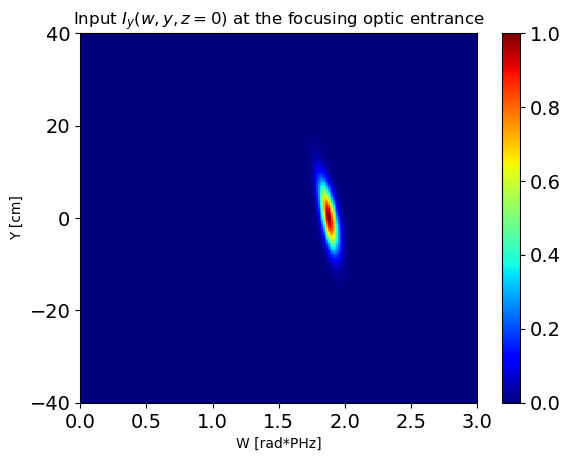

In [5]:
plt.figure()

ybound = Y_INPUT_RANGE
wbound = input_field.prop.omegas.max()
ew_input = laser_visualization.get_Ew_YW(input_field, z_val=0, is_Ey=True, ybound=ybound, wbound=wbound, is_output=False)

start_index = np.argmin(np.abs(input_field.prop.omegas - 0))
end_index = np.argmin(np.abs(input_field.prop.omegas - wbound))

ew_input_imshow = np.flip(ew_input[start_index:end_index, :].T, axis=0)

Iw_input_imshow = np.abs(ew_input_imshow) ** 2
Iw_input_imshow = Iw_input_imshow / Iw_input_imshow.max()

plt.imshow(Iw_input_imshow, aspect='auto', extent=[0, wbound, -ybound * 1e-4, ybound * 1e-4], cmap='jet', interpolation="None")
plt.xticks(np.array([0, .5, 1, 1.5, 2, 2.5, 3]), fontsize=14)
plt.yticks(np.array([-40, -20, 0, 20, 40]), fontsize=14)
cbar = plt.colorbar(ticks=[0, .2, .4, .6, .8, 1])
cbar.ax.tick_params(labelsize=14)
plt.xlabel('W [rad*PHz]')
plt.ylabel('Y [cm]')
plt.title("Input $I_{y}(w, y, z=0)$ at the focusing optic entrance")
plt.xlim(0, 3)
plt.ylim(-40, 40)

Here we use the `laser_visualization` plotting functions that will handle the plotting for us. We have less control over plotting, but it's much simpler to use.

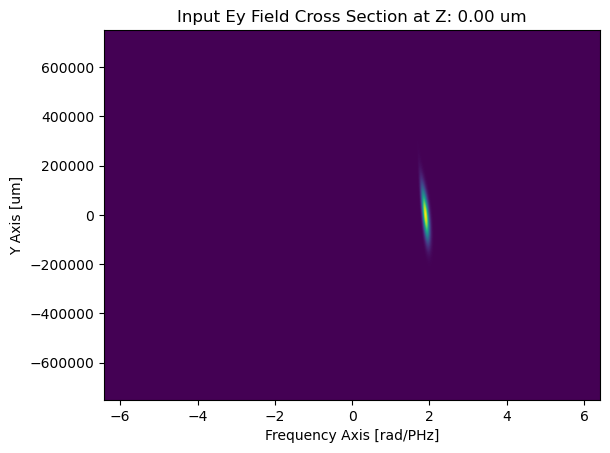

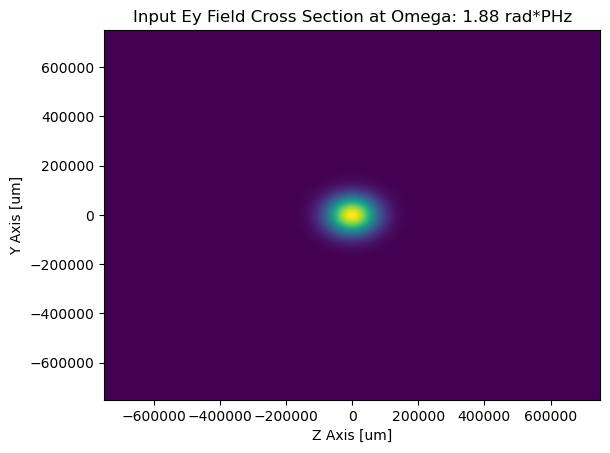

In [6]:
plt.figure()
laser_visualization.plot_Ew_input_YW(input_field, 0)

plt.figure()
laser_visualization.plot_Ew_input_transverse(input_field, input_field.laser.omega0, is_Ey=True)

## Stage 2: Output E field in frequency space

In stage 2, we propagate the laser field to `laser_parameters.output_distance_from_focus` away from the focus (negative values are closer to the focusing optic, positive values are away from the focusing optic. This will give us `E(Y, Z, W)` on the output grid. Then we plot it.

In [ ]:
print("Generating Output Ew Field")
propagator.generate_output_Ew_field(input_field)

Generating Output Ew Field


Again, we pull the data directly using the `laser_visualization` module to get the `Y, W` cross section at `Z = 0` for our output grid. Then we use our own plotting details.

In [ ]:
plt.figure()

ybound = Y_OUTPUT_RANGE
wbound = input_field.prop.omegas.max()
ew_output = laser_visualization.get_Ew_YW(input_field, z_val=0, is_Ey=True, ybound=ybound, wbound=wbound, is_output=True)

start_index = np.argmin(np.abs(input_field.prop.omegas - 0))
end_index = np.argmin(np.abs(input_field.prop.omegas - wbound))

ew_output_imshow = np.flip(ew_output[start_index:end_index, :].T, axis=0)

Iw_output_imshow = np.abs(ew_output_imshow)**2
Iw_output_imshow = Iw_output_imshow / Iw_output_imshow.max()

plt.imshow(Iw_output_imshow.real, aspect='auto', extent=[0, wbound, -ybound, ybound], cmap='jet', interpolation="None")
plt.xticks(np.array([0, .5, 1, 1.5, 2, 2.5, 3]), fontsize=14)
plt.yticks(np.array([-20, -10, 0, 10, 20]), fontsize=14)
cbar = plt.colorbar(ticks=[0, .2, .4, .6, .8, 1])
cbar.ax.tick_params(labelsize=14)
plt.xlabel('W [rad*PHz]')
plt.ylabel('Y [$\\mu m$]')
plt.title("Output $I_{y}(w, y, z=0)$ at " + str(OUTPUT_DISTANCE_FROM_FOCUS) + "$\\mu m$ from the focus")
plt.colorbar(label="I [arb. units]")
plt.xlim(0, 3)
plt.ylim(-20, 20)

Same as before, we can use the built-in plotting functions of the `laser_visualization` module if needed.

In [ ]:
plt.figure()
laser_visualization.plot_Ew_output_YW(input_field, 0)
plt.colorbar()

plt.figure()
laser_visualization.plot_Ew_output_transverse(input_field, input_field.laser.omega0, is_Ey=True)
plt.colorbar()

## Stage 3: Output E field in temporal space

For stage 3, we convert the output `E(Y, Z, W)` field from stage 2 into `E(Y, Z, T)` by using FFTs. Then we plot the field.

In [ ]:
print("Generating Output Et Field")
propagator.generate_output_Et_field_from_Ew(input_field)

Plotting by grabbing the data and defining our own plotting details.

In [ ]:
plt.figure()

ybound = Y_OUTPUT_RANGE
tbound = input_field.prop.times.max()
et_output = laser_visualization.get_Et_YT(input_field, z_val=0, is_Ey=True, ybound=ybound, tbound=tbound, is_output=True)

et_output_imshow = np.flip(et_output[:, :].T, axis=0)
et_output_imshow = et_output_imshow / np.abs(et_output_imshow.real).max()

plt.imshow(et_output_imshow.real, aspect='auto', extent=[-tbound, tbound, -ybound, ybound], cmap='bwr', interpolation="None")
plt.xticks(np.array([-40, -20, 0, 20, 40]), fontsize=14)
plt.yticks(np.array([-30, -20, -10, 0, 10, 20, 30]), fontsize=14)
cbar = plt.colorbar(ticks=[-1, -0.5, 0, 0.5, 1])
cbar.ax.tick_params(labelsize=14)
plt.xlabel('T [fs]')
plt.ylabel('Y [$\\mu m$]')
plt.title("Output $E_{y}(t, y, z=0)$ at " + str(OUTPUT_DISTANCE_FROM_FOCUS) + "$\\mu m$ from the focus")
plt.colorbar(label="E [arb. units]")
plt.colorbar()
plt.xlim(-50, 50)

Plotting by using the built-in functions.

In [ ]:
plt.figure()
laser_visualization.plot_Et_output_YT(input_field, 0)
plt.xlim(100, -100)
plt.colorbar()

plt.figure()
laser_visualization.plot_Et_output_transverse(input_field, 0, is_Ey=True)
plt.colorbar()

## Stage 4: Interpolated output E field to the PIC grid 

After stage 3, we have our focused laser beam defined on the output grid in `Y, Z, T` space. In order to use this field in PIC simulations, we need to interpolate this E field onto the PIC simulation grid. This is where the `read_laser` module will be used. 

In [17]:
print("Interpolating E Field")
read_laser.compute_field_at_sim_grid(input_field, utils.SingleThreadComm(), 0, 1, verbose=False)

Interpolating E Field


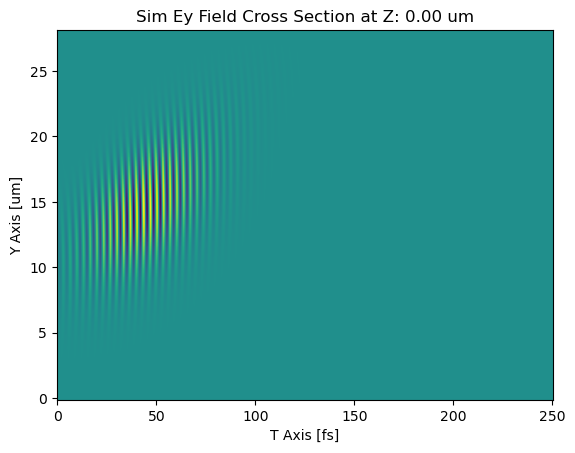

In [24]:
laser_visualization.plot_Et_sim_YT(input_field, z_val=0, is_Ey=True)

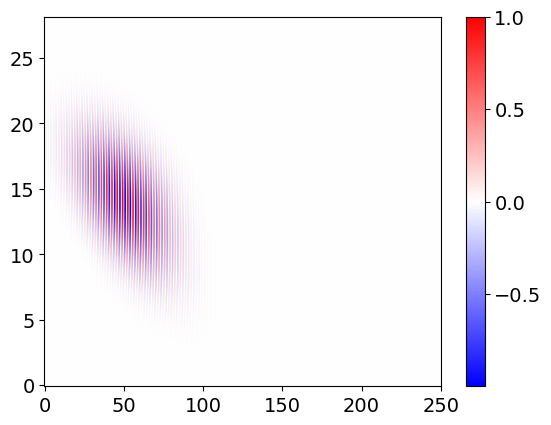

In [22]:
grid_params = sim_grid_parameters.compute_sim_grid(
    input_field.prop.times, input_field.prop.y_vals_output, input_field.prop.z_vals_output
)

Etyz_sim = np.memmap(
    input_field.prop.data_directory_path + constants.OUTPUT_ET_SIM_FILE_Y, dtype='complex64',
    mode='r+', shape=(grid_params.num_y_vals, grid_params.num_t_vals, grid_params.num_z_vals)
)

center_z = len(Etyz_sim[0, 0, :])//2
Etyz_sim = Etyz_sim[:, :, center_z]
Etyz_sim = Etyz_sim / np.abs(Etyz_sim).max()

times_sim = grid_params.sim_times_fs[:grid_params.num_t_vals]
y_sim = grid_params.sim_y_vals_um_half[grid_params.y_indexes.lo_index_sim_half:grid_params.y_indexes.hi_index_sim_half + 1]

plt.imshow(Etyz_sim.real, aspect='auto', 
                   extent=[times_sim[0], times_sim[-1], y_sim[0], y_sim[-1]], 
                   interpolation="none", cmap='bwr')
plt.xticks(np.array([0, 50, 100, 150, 200, 250]), fontsize=14)
plt.yticks(np.array([0, 5, 10, 15, 20, 25]), fontsize=14)
plt.xlabel("Time [fs]")
plt.ylabel("Y Position [$\mu$m]")
cbar = plt.colorbar(ticks=[-1, -0.5, 0, 0.5, 1])
cbar.ax.tick_params(labelsize=14)